In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

In [2]:
data_dir = "./data/Cotton Disease"
print(os.listdir(data_dir))

['test', 'train', 'val']


In [5]:
print(os.listdir(data_dir+'/train'))

['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


In [7]:
for i in os.listdir(data_dir+'/train'):
    print(f"No of images in {i} : {len(os.listdir(data_dir+'/train/'+i))}")

No of images in diseased cotton leaf : 288
No of images in diseased cotton plant : 815
No of images in fresh cotton leaf : 427
No of images in fresh cotton plant : 421


In [9]:
image_size = 32
batch_size = 128
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [11]:
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [13]:
train_ds = ImageFolder(data_dir+'/train',transform=transform)
val_ds = ImageFolder(data_dir+'/val',transform=transform)

In [15]:
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_dl = DataLoader(val_ds,batch_size=batch_size*2,num_workers=4,pin_memory=True)

In [17]:
def denorm(imgs):
    return imgs * stats[1][0] + stats[0][0]

In [19]:
def show_images(images,nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl,nmax=64):
    for img, _ in dl:
        show_images(img,nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0127522].


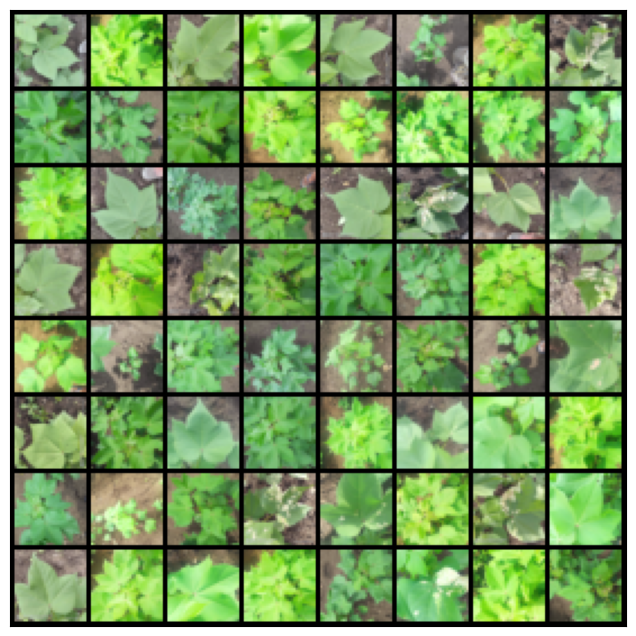

In [21]:
show_batch(train_dl)
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0127522].


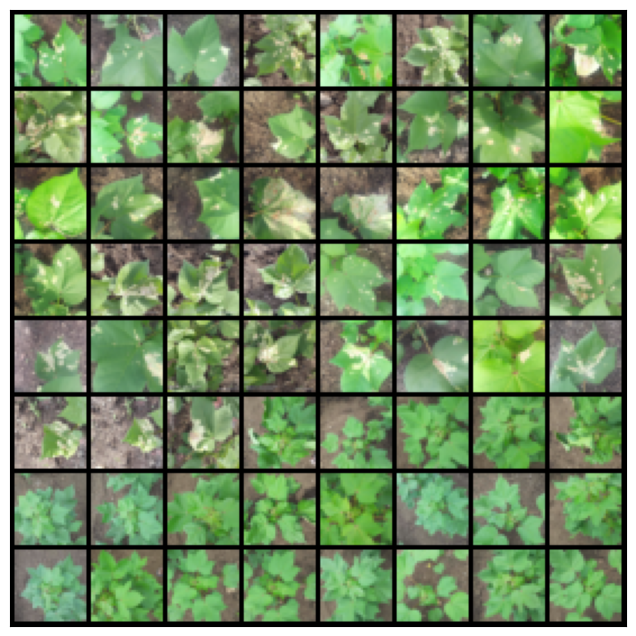

In [22]:
show_batch(val_dl)

In [25]:
for img,lbs in train_dl:
    print(lbs)
    break

tensor([2, 1, 1, 1, 1, 3, 0, 3, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 2, 1, 0, 2, 1, 3, 1, 1, 3, 3, 1, 2, 1, 3, 2, 2, 1, 2, 2, 3, 3, 3, 2,
        1, 3, 1, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 2, 3, 1, 1, 3, 2, 3, 2, 2, 2, 1,
        1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 2, 3, 0, 2, 1, 1, 2, 1, 0, 3, 0, 1, 0, 2,
        1, 3, 0, 1, 3, 0, 1, 2, 2, 3, 0, 3, 3, 1, 0, 2, 1, 3, 1, 0, 1, 0, 0, 2,
        2, 0, 3, 2, 2, 1, 1, 2])


In [27]:
class ImageClassificationBase(nn.Module):
    def train_step(self,batch):
        imgs,lbs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,lbs)
        return loss
    def val_step(self,batch):
        imgs,lbs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,lbs)
        acc = accuracy(out,lbs)
        return {"val_loss":loss.detach(), "val_acc":acc}

    def val_epoch_end(self,outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,epochs,result):
        print(f"Epoch {epoch}/{epochs}, train loss : {result['train_loss']:.4f}, val loss : {result['val_loss']:.4f}, val acc : {result['val_acc']:.2f}")

def accuracy(outputs,labels):
    _,pred = torch.max(outputs.data,1)
    return torch.tensor(torch.sum(pred == labels).item())/len(pred)

In [31]:
class CNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.neuralnet = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),#batch_size*32*32*32
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #batch_size*64*16*16
            
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),#batch_size*128*16*16
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #batch_size*128*8*8

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1), #batch_size*256*8*8
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #batch_size*256*4*4

            nn.Flatten(),
            nn.Linear(256*4*4,512), #batch_size*512
            nn.ReLU(),
            nn.Linear(512,4) #batch_size*4
        )
    def forward(self,x):
        return self.neuralnet(x)

In [33]:
model = CNN()
model

CNN(
  (neuralnet): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, o

In [35]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [37]:
device = get_default_device()
device

device(type='cuda')

In [39]:
_ = torch.randn(5,5)
_ = to_device(_,device)
_

tensor([[-1.4597, -0.2825, -0.1916,  0.5902,  1.5423],
        [ 1.5691,  0.1345, -0.3570,  1.1111,  0.3317],
        [-0.1745,  2.2364, -0.2594,  0.2724, -0.2341],
        [-0.5645, -0.9398, -1.3983,  1.4014, -0.1295],
        [-0.3716, -0.4272, -0.1302, -0.9864, -0.7943]], device='cuda:0')

In [41]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
to_device(model,device);

In [43]:
@torch.no_grad()
def evaluate(model,val_dl):
    model.eval()
    outputs = [model.val_step(batch) for batch in val_dl]
    return model.val_epoch_end(outputs)

def fit(epochs,model,train_dl,val_dl,opt_fun=torch.optim.SGD):
    history = []
    optimizer = opt_fun(model.parameters(),lr=0.001)
    for i in range(epochs):
        model.train()
        train_loss = []
        for batch in train_dl:
            loss = model.train_step(batch)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model,val_dl)
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(i+1,epochs,result)
        history.append(result)
    return history

In [45]:
model = to_device(CNN(),device)

In [47]:
evaluate(model,val_dl)

{'val_loss': 1.3836355209350586, 'val_acc': 0.260869562625885}

In [55]:
xtest = None
ytest = None
for im,lb in val_dl:
    xtest,ytest = im,lb
    break

In [ ]:
%%time
history = fit(epochs,model,train_dl,val_dl,opt_fun)

In [ ]:
def plot_accuracy(history):
    accuracy = [x['val_acc'] for x in history]
    plt.plot(accuracy,'-x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs No. of Epochs");

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plot_accuracy(history)

In [ ]:
def plot_loss(history):
    train_loss = [x['train_loss'] for x in history]
    val_loss = [x['val_loss'] for x in history]
    plt.plot(train_loss,'-bx')
    plt.plot(val_loss,'-rx')
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend(['Training','Validation'])
    plt.title("Losses vs Epochs")

In [ ]:
plot_loss(history)

In [ ]:
test_ds = ImageFolder(data_dir+'/test',transform=transform)

In [ ]:
dataset = ImageFolder(data_dir+'/train',transform=T.ToTensor())

In [ ]:
def predict(img,model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _,pred = torch.max(yb,1)
    return pred[0].item()

In [ ]:
index = 80
img,lbs = test_ds[index]
plt.imshow(denorm(img.permute(1,2,0)))
print(f"Original Label : {test_ds.classes[lbs]}, Predicted Label : {test_ds.classes[predict(img,model)]}")